In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
air = ['DESP','ERJ','BA','RTX','LMT']

In [3]:
df = yahoo.download(air,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  5 of 5 completed


LMT     1.060667
DESP    0.824931
BA      0.554939
ERJ     0.316406
RTX          NaN
dtype: float64

In [4]:
df

,BA,DESP,ERJ,LMT,RTX
Datetime,,,,,
2019-08-15 09:30:00-04:00,320.899994,10.910,17.920000,369.230011,NaN
2019-08-15 10:30:00-04:00,322.790009,10.880,17.950001,370.670013,NaN
2019-08-15 11:30:00-04:00,325.750000,10.890,18.010000,371.920013,NaN
2019-08-15 12:30:00-04:00,326.459991,10.720,17.930000,370.919891,NaN
2019-08-15 13:30:00-04:00,327.108398,10.520,17.989901,371.519989,NaN
...,...,...,...,...,...
2020-08-14 11:30:00-04:00,178.619995,9.000,5.680000,392.799988,64.029999
2020-08-14 12:30:00-04:00,178.133698,9.015,5.650000,391.950012,64.023399
2020-08-14 13:30:00-04:00,178.376007,9.000,5.665000,392.450012,63.930000


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = 20
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

RTX     0.300
LMT     0.300
DESP    0.236
BA      0.086
ERJ     0.078
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


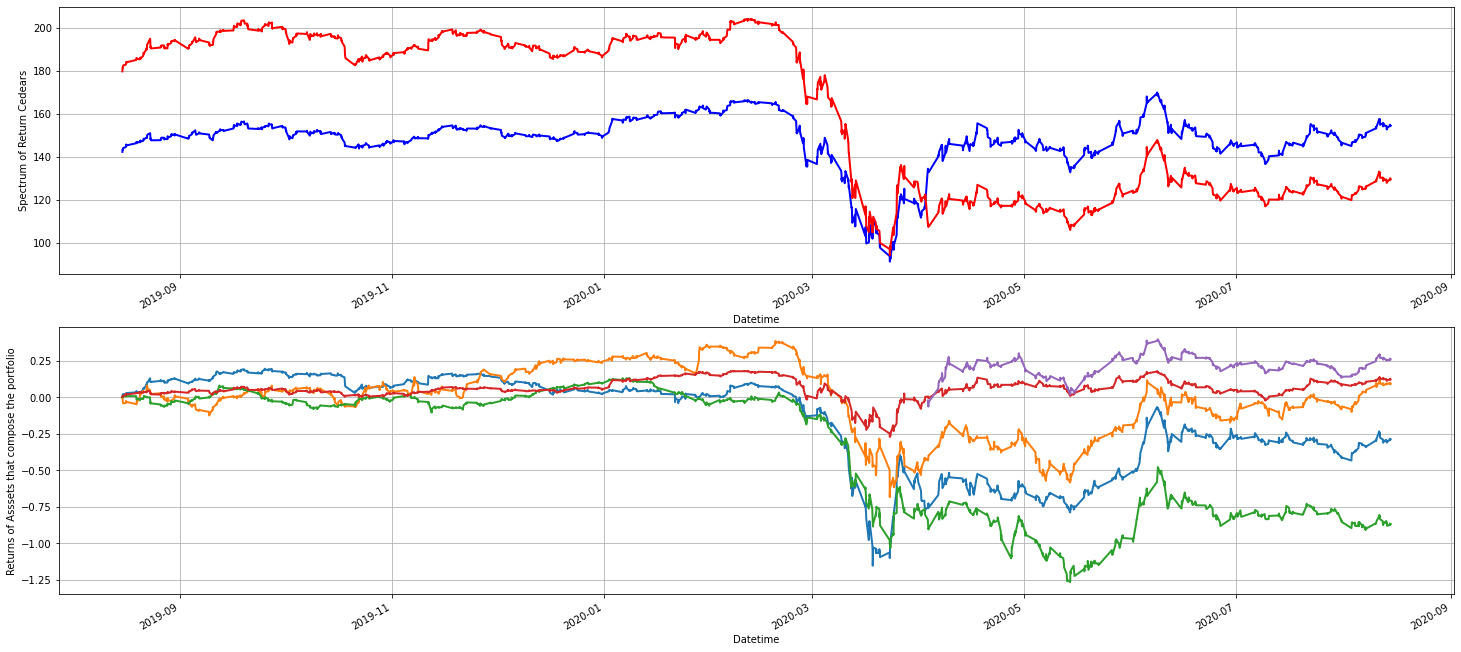

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00    142.338923
 2019-08-15 10:30:00-04:00    142.928725
 2019-08-15 11:30:00-04:00    143.565324
 2019-08-15 12:30:00-04:00    143.279987
 2019-08-15 13:30:00-04:00    143.473251
                                 ...    
 2020-08-14 11:30:00-04:00    154.977356
 2020-08-14 12:30:00-04:00    154.679762
 2020-08-14 13:30:00-04:00    154.820210
 2020-08-14 14:30:00-04:00    154.233259
 2020-08-14 15:30:00-04:00    154.465142
 Length: 1765, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00    179.740001
 2019-08-15 10:30:00-04:00    180.572506
 2019-08-15 11:30:00-04:00    181.642503
 2019-08-15 12:30:00-04:00    181.507471
 2019-08-15 13:30:00-04:00    181.784572
                                 ...    
 2020-08-14 11:30:00-04:00    130.025996
 2020-08-14 12:30:00-04:00    129.754422
 2020-08-14 13:30:00-04:00    129.884204
 2020-08-14 14:30:00-04:00    129.365160
 2020-08-14 15:30:00-04:00    129.606002
 Length: 1765, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

RTX     0.30
LMT     0.30
DESP    0.24
BA      0.09
ERJ     0.08
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00    143.702003
2019-08-15 10:30:00-04:00    144.299305
2019-08-15 11:30:00-04:00    144.947904
2019-08-15 12:30:00-04:00    144.664567
2019-08-15 13:30:00-04:00    144.859745
                                ...    
2020-08-14 11:30:00-04:00    155.739196
2020-08-14 12:30:00-04:00    155.439656
2020-08-14 13:30:00-04:00    155.581044
2020-08-14 14:30:00-04:00    154.990439
2020-08-14 15:30:00-04:00    155.224802
Length: 1765, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
BA,0.2,0.655616,0.018445,0.036278,0.144953
DESP,0.2,0.588058,0.017880,0.031544,0.144953
ERJ,0.2,0.623727,0.017738,0.033191,0.144953
LMT,0.2,0.636135,0.008519,0.016258,0.144953
RTX,0.2,0.708107,0.013031,0.027682,0.144953


In [15]:
poe, fullstress

(BA      -9.484659
 DESP   -10.385204
 ERJ    -13.277635
 LMT    -11.558776
 RTX     -4.765876
 dtype: float64,
 -1.432225876600515)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00    179.740001
2019-08-15 10:30:00-04:00    180.572506
2019-08-15 11:30:00-04:00    181.642503
2019-08-15 12:30:00-04:00    181.507471
2019-08-15 13:30:00-04:00    181.784572
                                ...    
2020-08-14 11:30:00-04:00    130.025996
2020-08-14 12:30:00-04:00    129.754422
2020-08-14 13:30:00-04:00    129.884204
2020-08-14 14:30:00-04:00    129.365160
2020-08-14 15:30:00-04:00    129.606002
Length: 1765, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
BA,0.000612,-0.024868,0.024608,0.016134,0.052887,0.010577,0.039976,0.264597
DESP,0.000488,-0.024868,0.019625,0.011541,0.033933,0.006787,0.039976,0.169766
ERJ,0.000555,-0.024868,0.022319,0.013921,0.043415,0.008683,0.039976,0.217208
LMT,0.000234,-0.024868,0.009406,0.005984,0.019032,0.003806,0.039976,0.095217
RTX,0.000502,-0.024868,0.020187,0.014295,0.050612,0.010122,0.039976,0.253212


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
BA,0.2,0.264597,0.09,0.052919,0.023814,-0.029106,-0.55,0.0405,1.2605,0.032130
DESP,0.2,0.169766,0.24,0.033953,0.040744,0.006791,0.20,0.2880,1.2605,0.228481
ERJ,0.2,0.217208,0.08,0.043442,0.017377,-0.026065,-0.60,0.0320,1.2605,0.025387
LMT,0.2,0.095217,0.30,0.019043,0.028565,0.009522,0.50,0.4500,1.2605,0.357001
RTX,0.2,0.253212,0.30,0.050642,0.075963,0.025321,0.50,0.4500,1.2605,0.357001


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

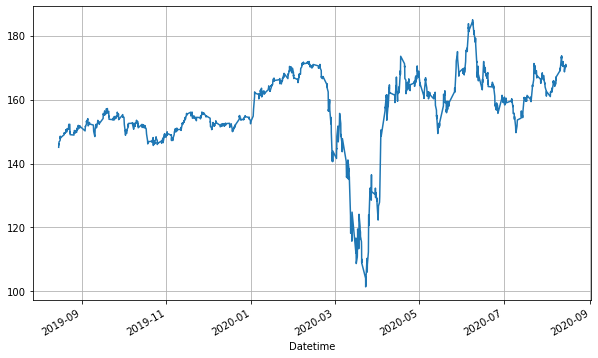

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00    145.073760
2019-08-15 10:30:00-04:00    145.642476
2019-08-15 11:30:00-04:00    146.187641
2019-08-15 12:30:00-04:00    145.812535
2019-08-15 13:30:00-04:00    146.003429
                                ...    
2020-08-14 11:30:00-04:00    171.028452
2020-08-14 12:30:00-04:00    170.709695
2020-08-14 13:30:00-04:00    170.859591
2020-08-14 14:30:00-04:00    170.225259
2020-08-14 15:30:00-04:00    170.457503
Length: 1765, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

RTX     0.357001
LMT     0.357001
DESP    0.228481
BA      0.032130
ERJ     0.025387
Name: MinCVaR, dtype: float64